<a href="https://colab.research.google.com/github/nkolln/DataChallenge1/blob/master/CyberTruck_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-_h22iiwx
  Running command git clone -q git://github.com/fchollet/keras.git /tmp/pip-req-build-_h22iiwx
  Created wheel for Keras: filename=Keras-2.3.1-cp36-none-any.whl size=365121 sha256=fc5841dced6a11954c0c5c824381a717b2ef27fec1c83a5fd3963a50f2a2564c
  Stored in directory: /tmp/pip-ephem-wheel-cache-54cshh4k/wheels/dc/a7/a2/8b2d0fd23dee9c609b4c95f2b5ed27997ed17ccbeabbebfc64
Successfully built Keras
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Keras and TensorFlow are the primary ones that used throughout the whole project.

In [0]:
%tensorflow_version 1.x
import itertools
import multiprocessing.pool
import threading
from functools import partial
from keras.models import load_model
from keras.models import Model
import keras
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.backend import relu, sigmoid
import numpy as np
import time
import argparse
import glob
import json
import os
import numpy as np
from tensorflow.python.lib.io import file_io
from skimage import exposure, color
import tensorflow as tf
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter
import os

Using TensorFlow backend.


#Setting up the model

Creating a Sequential Model with Keras which has 3 convolutional layers, 2 max pooling layers in order to down sample input representations. Furthermore, relu activations is used to increase non-linearity in one of the dense layers. In the other dense layer, softmax is used as activation.

Also, Adam learning rate optimizer is used with a small starting value of 0.01. 

As a loss-function categorical crossentropy is used, however custom designed loss function will most likely work better.


In [0]:
def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""

    model = models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128, 128, 3)))
    #model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(labels_dim, activation='softmax', kernel_initializer='glorot_uniform'))

    compile_model(model)
    return model

def compile_model(model):
    opt =keras.optimizers.adam(lr=0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def read_train_data():
    start_time = time.time()
    print("Start Read Train Data")
    data = np.load("trainDataSmall.npz")
    #data = np.load("/content/drive/My Drive/Colab Notebooks/trainDataSmall.npz")
    print("Train data read --- %s seconds ---" % (time.time() - start_time))
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    print("Training - Total examples per class", np.sum(Y_train, axis=0))
    return [X_train, Y_train]

def read_test_data():
    start_time = time.time()
    print("Start Read Test Data")
    data = np.load("testDataSmall.npz")
    print("Test data read --- %s seconds ---" % (time.time() - start_time))
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    print("Testing - Total examples per class", np.sum(Y_test, axis=0))
    return [X_test, Y_test]

Downloading the training and test data from the TU/e server.

In [0]:
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"

In [0]:
def AHE(image):
    image = exposure.equalize_adapthist(image, clip_limit=0.01)
    
                    
datagen1 = ImageDataGenerator(
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True,
        preprocessing_function=AHE
        )

class ContinuousEval(keras.callbacks.Callback):
    """Continuous eval callback to evaluate the checkpoint once
       every so many epochs.
    """

    def __init__(self,
                 eval_frequency,
                 job_dir):
        self.eval_frequency = eval_frequency
        self.job_dir = job_dir
        [self.X_test, self.Y_test] = read_test_data()
        datagen1.fit(self.X_test)

    def on_epoch_begin(self, epoch, logs={}):
        if epoch > 0 and epoch % self.eval_frequency == 0:
            # Unhappy hack to work around h5py not being able to write to GCS.
            # Force snapshots and saves to local filesystem, then copy them over to GCS.
            model_path_glob = 'checkpoint.*'
            model_path_glob = os.path.join(self.job_dir, model_path_glob)
            checkpoints = glob.glob(model_path_glob)
            if len(checkpoints) > 0:
                checkpoints.sort()
                retinopathy_model = load_model(checkpoints[-1])
                retinopathy_model = compile_model(retinopathy_model)
                loss, acc = retinopathy_model.evaluate(
                    self.X_test, self.Y_test)
                print('\nEvaluation epoch[{}] metrics[{:.2f}, {:.2f}] {}'.format(
                    epoch, loss, acc, retinopathy_model.metrics_names))
            else:
                print('\nEvaluation epoch[{}] (no checkpoints found)'.format(epoch))
                
# Continuous eval callback
evaluation = ContinuousEval(5, 'job_dir')
validation=(evaluation.X_test, evaluation.Y_test)

Start Read Test Data
Test data read --- 0.002245187759399414 seconds ---
Testing - Total examples per class [500. 500. 500. 500. 500.]


In [0]:
"""This code implements a Feed forward neural network using Keras API."""

CLASS_SIZE = 5
FILE_PATH = 'checkpoint.{epoch:02d}.hdf5'
RETINOPATHY_MODEL = 'retinopathy.hdf5'

def run():
    tf.keras.backend.clear_session()
    #local dir to write checkpoints and export model
    job_dir = 'jobdir'
    #Batch size for training steps
    train_batch_size = 200
    #Maximum number of epochs on which to train
    num_epochs = 30
    #Checkpoint per n training epochs
    checkpoint_epochs = 5
    #Perform one evaluation per n epochs
    eval_frequency = 5

    retinopathy_model = model_fn(CLASS_SIZE)

    try:
        os.makedirs(job_dir)
    except:
        pass

    # Unhappy hack to work around h5py not being able to write to GCS.
    # Force snapshots and saves to local filesystem, then copy them over to GCS.
    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        period=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        write_graph=True,
        embeddings_freq=0)

    callbacks = [checkpoint, evaluation, tblog]

    [X_train, Y_train] = read_train_data()
    datagen1.fit(X_train)
    
    datagen = ImageDataGenerator(
        shear_range=0,
        zoom_range=0,
        horizontal_flip=True)
    
    history = retinopathy_model.fit_generator(
        datagen.flow(X_train, Y_train, batch_size=train_batch_size),
        steps_per_epoch=100,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=2,
        validation_data=validation)

    retinopathy_model.save(os.path.join(job_dir, RETINOPATHY_MODEL))
    retinopathy_model.summary()
    
    # Creating a plot for loss and accuracy for both training and validation set.
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], 'bo')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'test_acc'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], 'bo')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('Training and Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'test_loss'], loc='upper left')
    plt.show()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Start Read Train Data
Train data read --- 0.0005564689636230469 seconds ---
Training - Total examples per class [1000. 1000. 1000. 1000. 1000.]



Epoch 1/30
 - 17s - loss: 1.5645 - accuracy: 0.2638 - val_loss: 1.4204 - val_accuracy: 0.3432

Epoch 2/30
 - 14s - loss: 1.4738 - accuracy: 0.3198 - val_loss: 1.3736 - val_accuracy: 0.3636
Epoch 3/30
 - 14s - loss: 1.4345 - accuracy: 0.3433 - val_loss: 1.3358 - val_accuracy: 0.3848
Epoch 4/30
 - 14s - loss: 1.3831 - accuracy: 0.3726 - val_loss: 1.3685 - val_accuracy: 0.3616
Epoch 5/30
 - 14s - loss: 1.3369 - accuracy: 0.4053 - val_loss: 1.2903 - val_accuracy: 0.4120

Epoch 00005: saving model to jobdir/checkpoint.05.hdf5
Epoch 6/30

Evaluation epoch[5] (no checkpoints found)
 - 14s - loss: 1.2569 - accuracy: 0.4469 - val_loss: 1.2961 - val_accuracy: 0.4048
Epoch 7/30
 - 14s - loss: 1.1684 - accuracy: 0.4979 - val_loss: 1.3040 - val_accuracy: 0.4216
Epoch 8/30
 

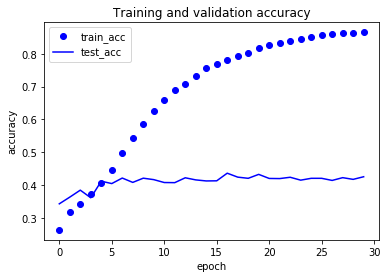

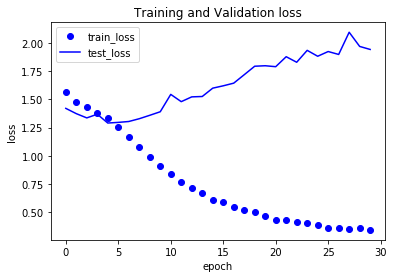

In [0]:
!rm -fr jobdir/
run()